## Модель распространения частичной разметки фаций в 3D сейсмике

## Содержание
* [Постановка задачи](#Постановка задачи)
* [Датасет](#Датасет)
* [Архитектура](#Архитектура)
* [Обучение](#Обучение)
* [Оценка модели](#Оценка-модели)
* [Инференс](#Инференс)
* [Критика](#Критика)
* [Краткое резюме](#Краткое-резюме)
* [Предложения по улучшению и развитию](#Предложения-по-улучшению-и-развитию)

## Постановка задачи
Распространить частичную разметку фаций, выполенную на некоторых срезах 3D куба сейсмики, на весь куб сейсмики.

## Датасет

Используется датасет Dutch F3 из открытого источника [https://drive.google.com/drive/folders/0B7brcf-eGK8CRUhfRW9rSG91bW8](https://drive.google.com/drive/folders/0B7brcf-eGK8CRUhfRW9rSG91bW8). Датасет состоит из файла с 3D кубом сейсмических данных и набора файлов с разметкой на каждый тип фаций.

Основные параметры куба сейсмики:
* размер (651, 951, 462) по осям (i-line, x-line, samples)
* формат `segy`

Основные параметры разметки:
* 10 типов фациальных структур
    * f3_fault_training locations
    * multi_steep_dips_ilxl
    * multi_high_amplitude_ilxl 
    * multi_else_ilxl  
    * multi_grizzly_ilxl  
    * multi_high_amp_continuous_ilxl    
    * multi_salt_ilxl             
    * multi_low_amplitude_ilxl     
    * multi_low_amp_dips_ilxl 
* формат `pts` (координаты точек куба, относящиеся к данному типу фаций)
* от 7К до 20К точек на разные типы фаций.

Для обучения `f3_fault_training locations` не используется.

Процедура определения датасета:

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from skimage.transform import resize
from matplotlib import cm

from dataset import Dataset, FilesIndex, B, V, F, C
from dataset.models.tf import TFModel
from dataset import best_practice

from seismic_batch import SeismicBatch
from utils import IndexTracker, get_pts

dindex = FilesIndex(path="/home/egor/Desktop/Dutch F3 seismic data/D*.segy")
imset = Dataset(dindex, SeismicBatch)

Загрузка куба сейсмики и разметки:

In [2]:
batch = imset.next_batch(1).load(fmt="segy").load(fmt="pts")

Размеры куба

In [3]:
original_shape = batch.traces[0].shape
original_shape

(651, 951, 462)

Просмотр куба вдоль любой размерности (параметр `slice_axis`). Скролл по картинке переключает срезы c шагом `scroll_step`.

<IPython.core.display.Javascript object>


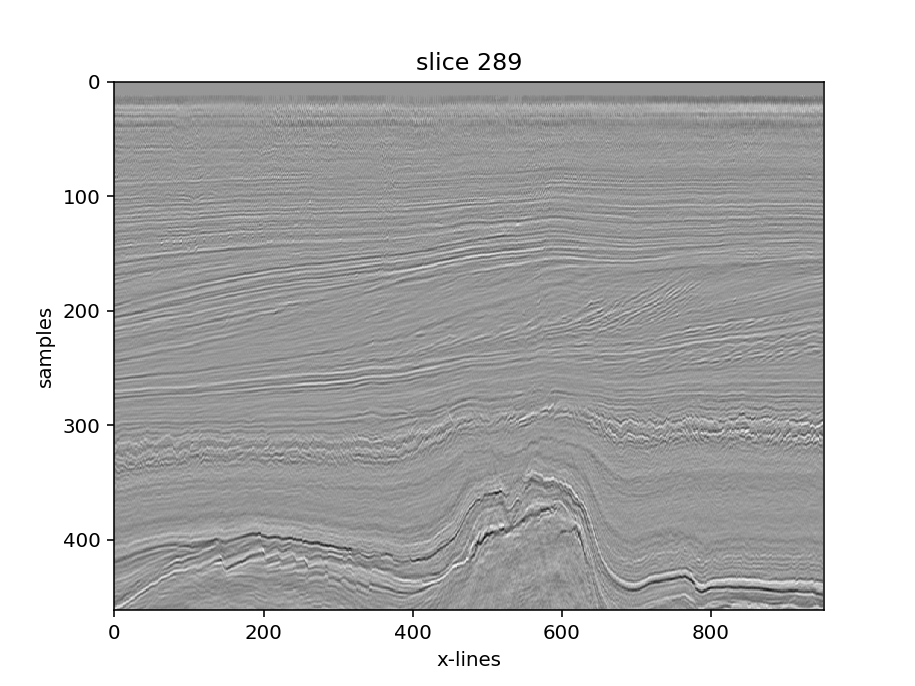

In [4]:
%matplotlib notebook

slice_axis = 0
scroll_step = 1

fig, tracker = batch.slice_tracker(batch.indices[0], axis=slice_axis,
                                   scroll_step=scroll_step, show_pts=True)
fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

Просмотр срезов 239  и 242 с размеченными фациями:

<IPython.core.display.Javascript object>


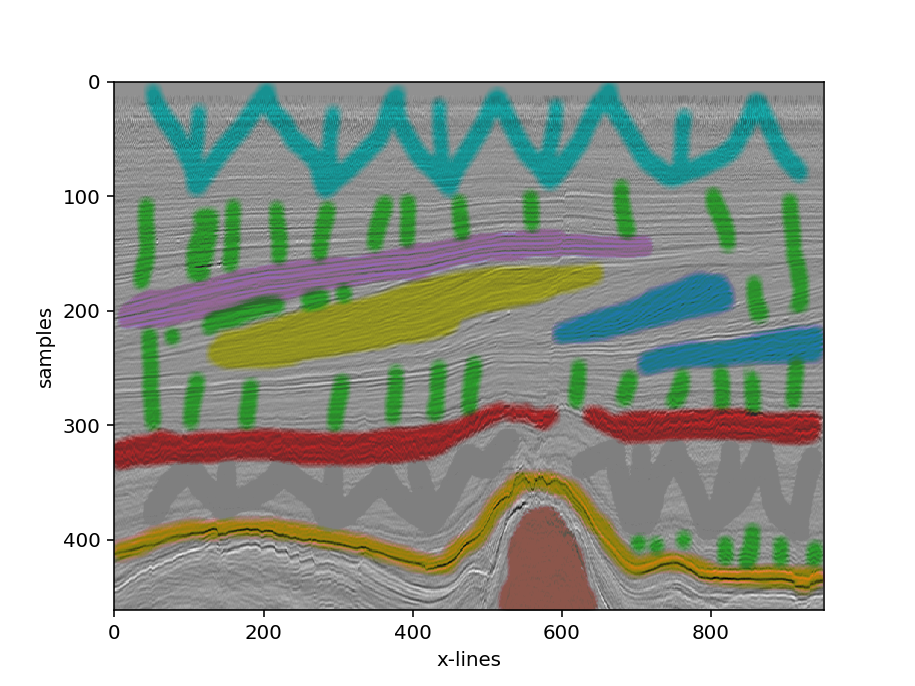

In [5]:
%matplotlib notebook

slice_axis = 0
slice_offset = 239

batch.show_slice(batch.indices[0], slice_axis, slice_offset, show_pts=True, cmap="gray")

<IPython.core.display.Javascript object>


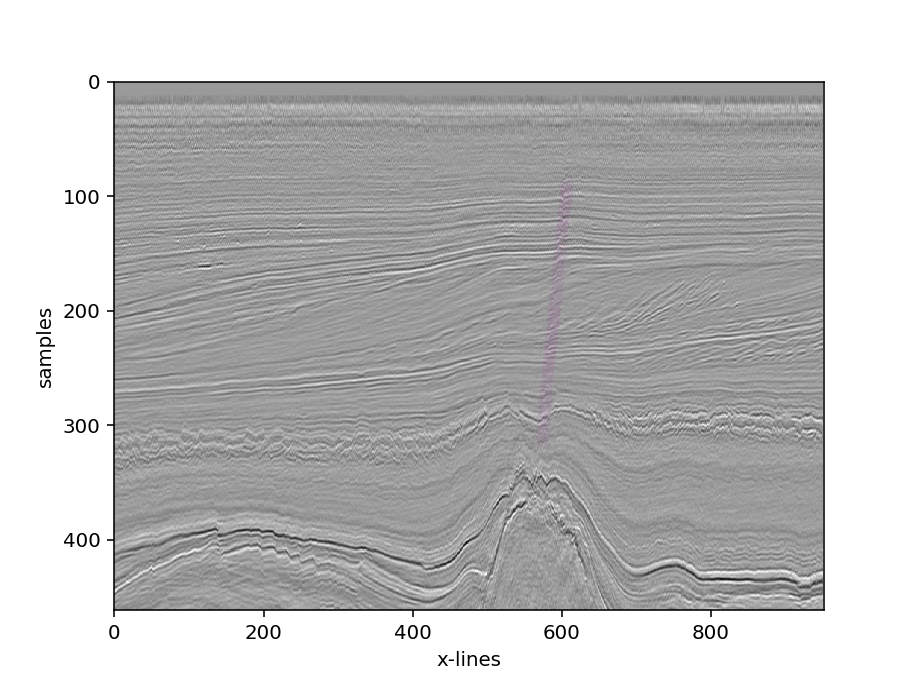

In [6]:
%matplotlib notebook

slice_axis = 0
slice_offset = 242

batch.show_slice(batch.indices[0], slice_axis, slice_offset, show_pts=True, cmap="gray")

Создание одного сэмла кропов, по которым будет происходить обучение. Кроп имееют размеры 64х64 по пространственной размерности.

In [7]:
crop_size = 64
imbatch = batch.sample_crops((1, crop_size, crop_size), origin=[[239, 150, 140]])

Отрисовка кропа:

<IPython.core.display.Javascript object>


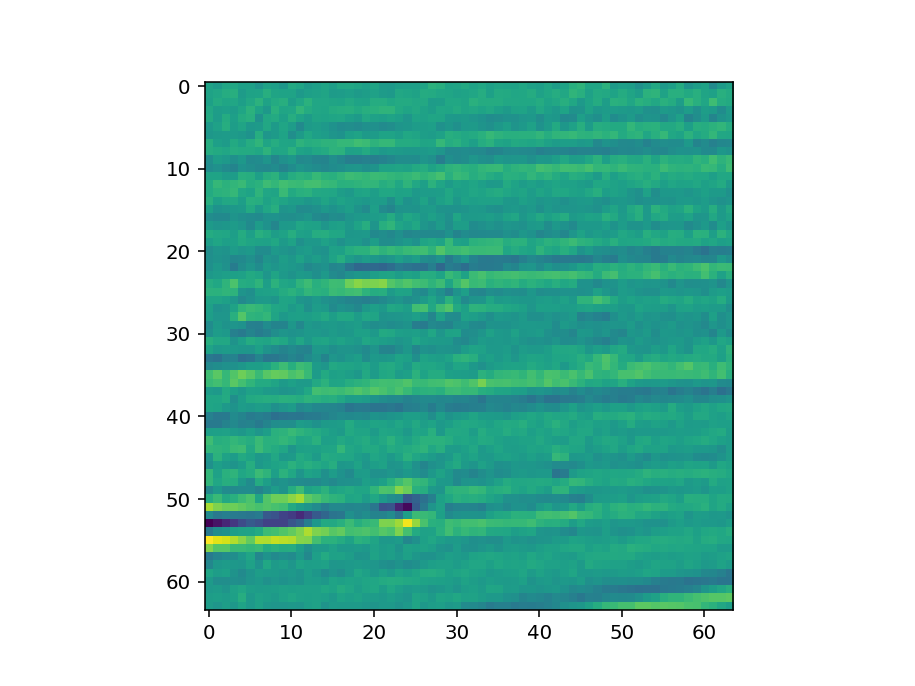

In [9]:
%matplotlib notebook
crop = imbatch.images[0]
plt.imshow(crop[0, :, :].T)
plt.show()

## Архитектура

Используется модель сверточной нейронной сети, состоящая из последовательности слоев
`cna cnapd cnapd cnapd`.

Конфигурация модели:
* размерность входного слоя (64, 64, 1)
* размерность выходного слоя 9
* число фильтров в светрках 12, 16, 24, 32
* активация для сверток `relu`
* `dropout_rate` =.1.

Задание конфигурации модели:

In [14]:
num_classes = len(glob.glob("/home/egor/Desktop/Dutch F3 seismic data/m*.pts"))

model_config = {
    'inputs': dict(images={'shape': B('image_shape')},
                   labels={'classes': num_classes, 
                           'transform': 'ohe', 
                           'name': 'targets'}),
    'input_block/inputs': 'images',
    'body': dict(layout='cna cnapd cnapd cnapd cnapd cnapd', filters=[8, 12, 16, 24, 32, 48],
                 kernel_size=3, strides=1, dropout_rate=.1),
    'head': dict(layout='f', units=num_classes),
    'input_block/inputs': 'images',
    'loss': 'crossentropy',
    'optimizer': 'Adam',
    'output': ['proba']
}

## Обучение

Обучение проcходит итерациями по батчам. Итерации состоит из:
* загрузки куба сейсмики и разметки
* генерация набора кропов с центрами в размеченных точках
* итерирование по поднаборам кропов и обновление весов нейронной сети.

Для обновления весов используется оптимизатор `Adam` с параметрами:
* ```learning_rate``` = 0.001
* ```beta1``` = 0.9
* ```beta2``` = 0.999
* ```epsilon``` = 1e-08.

Функция потерь `cross-entropy`.

Схема обхода датасета:
* ```batch_size``` = 1
* ```crop_batch_size``` = 1000
* ```minibatch_size``` = 50
* ```n_epochs``` = 20.

Описание пайплайна обучения:

In [15]:
minibatch_size = 50
crop_size = 64

train_pipeline = (imset.p
                  .load(fmt="segy")
                  .load(fmt="pts")
                  .filter_annotations(["f3_fault_training locations.pts"], mode="drop")
                  .init_variable('loss', init_on_each_run=list)
                  .init_model('dynamic', TFModel, 'cnet', config=model_config)
                  .sample_crops((1, crop_size, crop_size), n_crops=1000,
                                 origin="random_annotated_balanced")
                  .apply_transform(np.transpose, axes=(1, 2, 0), src='images', dst='images')
                  .rebatch(minibatch_size)
                  .train_model('cnet', fetches='loss',
                              feed_dict={'images': B('images'),
                                         'labels': B('labels')},
                              save_to=V('loss'), mode='a'))

Запуск обучения

In [16]:
train_pipeline.run(1, n_epochs=20, bar=True)

 95%|█████████▌| 19/20 [03:15<00:10, 10.65s/it]


График функции потерь в зависимости от числа итераций:

<IPython.core.display.Javascript object>


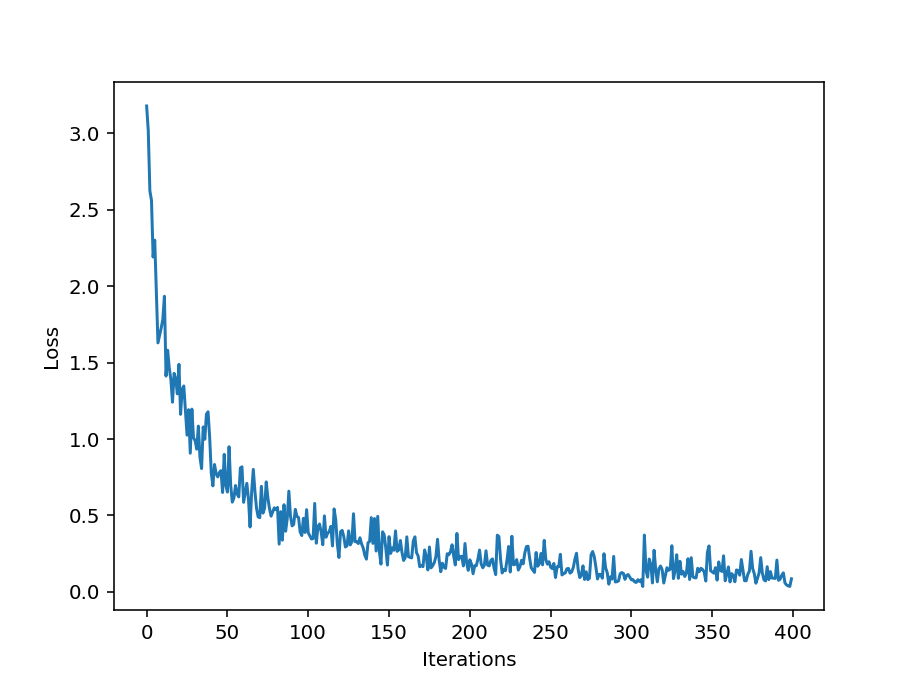

In [17]:
%matplotlib notebook
loss = train_pipeline.get_variable("loss")
plt.plot(loss)
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.show()

## Оценка модели

Качество модели оценивается по метрикам `precision`, `recall` и `f1-score` по случайной выборке из 1000 кропов с центрами в размеченных точках .

Описание тестового пайплайна:

In [18]:
test_pipeline = (imset.p
                 .load(fmt="segy")
                 .load(fmt="pts")
                 .filter_annotations(["f3_fault_training locations.pts"], mode="drop")
                 .init_variable('predictions')
                 .init_variable('targets', init_on_each_run=list())
                 .init_variable('metrics', init_on_each_run=None)
                 .import_model('cnet', train_pipeline)
                 .sample_crops((1, crop_size, crop_size), n_crops=1000,
                               origin="random_annotated_balanced")
                 .apply_transform(np.transpose, axes=(1, 2, 0), src='images', dst='images')
                 .update_variable('targets', B('labels'), mode='e')
                 .predict_model('cnet', fetches='proba',
                                feed_dict={'images': B('images')},
                                save_to=V('predictions'))
                 .gather_metrics('class', num_classes=num_classes,
                                 targets=B('labels'), predictions=V('predictions'),
                                 fmt='proba', axis=-1,
                                 save_to=V('metrics')))

Запуск тестового пайплайна

In [19]:
test_pipeline.run(1, n_epochs=1, bar=False)

Расчет аггрегированных метрик:

In [20]:
m = test_pipeline.get_variable("metrics")
m.evaluate(['precision', 'recall', 'f1_score'])

{'precision': array(0.98208373),
 'recall': array(0.98033084),
 'f1_score': 0.9812065044058291}

Расчет метрик по отдельным классам:

In [21]:
true_labels = test_pipeline.get_variable('targets')
pred_labels = np.argmax(test_pipeline.get_variable('predictions'), axis=-1)
label_names = [os.path.split(p)[1][:-4] for p in
               glob.glob("/home/egor/Desktop/Dutch F3 seismic data/*.pts")]

print(classification_report(true_labels, pred_labels, target_names=label_names))

                                precision    recall  f1-score   support

         multi_steep_dips_ilxl       0.99      1.00      1.00       107
     multi_high_amplitude_ilxl       1.00      0.98      0.99       118
               multi_else_ilxl       0.99      0.85      0.91       105
            multi_grizzly_ilxl       0.99      1.00      1.00       107
multi_high_amp_continuous_ilxl       0.98      0.99      0.98       130
               multi_salt_ilxl       0.98      1.00      0.99       107
   f3_fault_training locations       0.99      1.00      1.00       114
      multi_low_amplitude_ilxl       0.93      1.00      0.96       117
       multi_low_amp_dips_ilxl       0.99      1.00      0.99        95

                   avg / total       0.98      0.98      0.98      1000



##  Инференс

Инференс проводится по точкам с заданными координатами. Рассмотрим процедуру инференса по равнометрной 2D и 3D сетке. Для ускорения процедуры разрешение сетки берется в 5 и 10 раз ниже по сравнению с разрешением исходных данных.

Задание 2D сетки для инференса 239 срезу (срез с частичной разметкой):

In [22]:
reduce_factor = 5
img_shape = tuple(np.array(original_shape[1:]) // reduce_factor)
grid_2d = np.indices((1,) + img_shape).reshape((3, -1)).T
grid_2d *= reduce_factor
grid_2d[:, 0] = 239

Описание процедуры инференса:

In [23]:
predict_pipeline = (imset.p
                    .load(fmt="segy")
                    .init_variable("i", init_on_each_run=0)
                    .init_variable("pts", init_on_each_run=None)
                    .import_model('cnet', train_pipeline)
                    .init_variable('predictions', init_on_each_run=list())
                    .update_variable("pts", F(get_pts, C("grid"), V("i"), 1000))
                    .sample_crops((1, crop_size, crop_size), origin=V("pts"))
                    .apply_transform(np.transpose, axes=(1, 2, 0), src='images', dst='images')
                    .predict_model('cnet', fetches='proba',
                                   feed_dict={'images': B('images')},
                                   save_to=V('predictions'), mode="a")
                    .update_variable("i", F(lambda _, i: i + 1, V("i"))))

Запуск инференса по 2D срезу:

In [24]:
predict_pipeline.set_config({"grid": grid_2d}).run(1, n_epochs=None, bar=False)

Сборка размеченного среза:

In [25]:
predicts = np.vstack(predict_pipeline.get_variable("predictions"))
predicted_img = np.argmax(predicts, axis=-1).reshape(img_shape)

Отрисовка размеченных фаций:

<IPython.core.display.Javascript object>


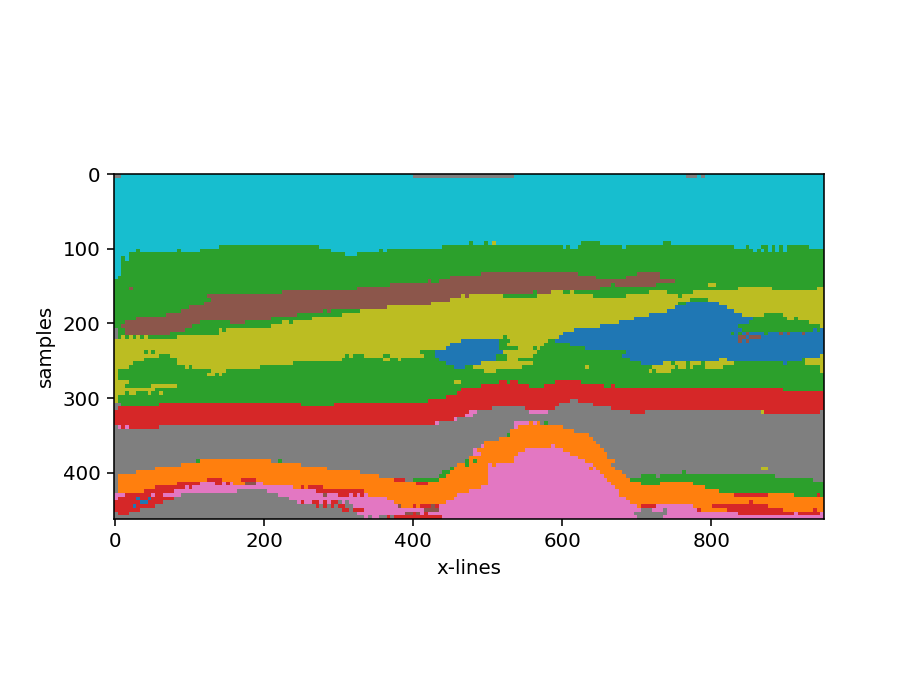

In [26]:
%matplotlib notebook

axes_names = np.delete(["i-lines", "x-lines", "samples"], 0)
plt.imshow(resize(predicted_img, original_shape[1:], order=0).T, cmap="tab10")
plt.xlabel(axes_names[0]), plt.ylabel(axes_names[1])
plt.show()

Задание 3D сетки для инференса по всему кубу:

In [27]:
reduce_factor = 10
cube_shape = tuple(np.array(original_shape) // reduce_factor)
grid_3d = np.indices(cube_shape).reshape((3, -1)).T
grid_3d *= reduce_factor

Запуск разметки куба:

In [28]:
predict_pipeline.set_config({"grid": grid_3d}).run(1, n_epochs=None, bar=False)

Сборка размеченного куба:

In [29]:
predicts = np.vstack(predict_pipeline.get_variable("predictions"))
predicted_cube = np.argmax(predicts, axis=-1).reshape(cube_shape)

Просмотро размеченного куба вдоль произвольной оси (параметр `slice_axis`):

<IPython.core.display.Javascript object>


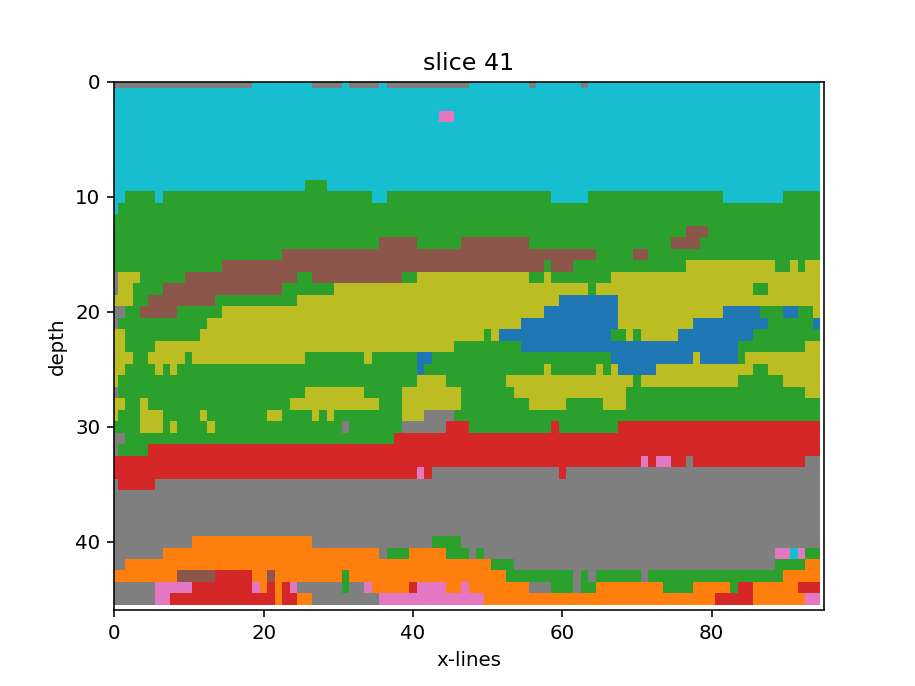

In [33]:
%matplotlib notebook

slice_axis = 0
scroll_step = 1

order = np.hstack((np.delete(np.arange(3), slice_axis)[::-1], slice_axis))
axes_names = np.delete(["i-lines", "x-lines", "depth"], slice_axis)
fig, ax = plt.subplots(1, 1)
tracker = IndexTracker(ax, np.transpose(predicted_cube, order),
                       cmap="tab10", axes_names=axes_names)
fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

<IPython.core.display.Javascript object>


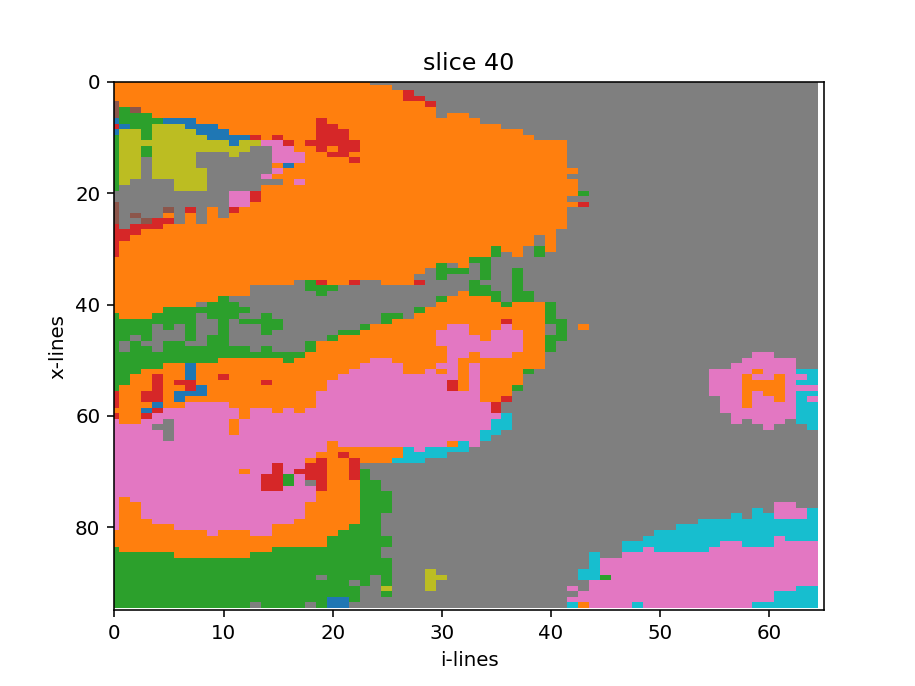

In [32]:
%matplotlib notebook

slice_axis = 2
scroll_step = 1

order = np.hstack((np.delete(np.arange(3), slice_axis)[::-1], slice_axis))
axes_names = np.delete(["i-lines", "x-lines", "depth"], slice_axis)
fig, ax = plt.subplots(1, 1)
tracker = IndexTracker(ax, np.transpose(predicted_cube, order),
                       cmap="tab10", axes_names=axes_names)
fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

## Критика

Как видно из картинок выше, в однородных структурах встречаются неожиданные вкропления другий фаций. По-видимому, это происходит из-за того, что модель размечает точки независимо и недостаточного учитывает окружающую среду.

## Краткое резюме

Модель, обученная на одном частично размеченном срезе куба, позволяет дополнять разметку этого среза и распространять ее на весь куб. При этом сохраняется глобальная непрерывность стурктур. Локальные нехарактерные  включения фаций можно связать с недостаточным учетом окружающей среды при разметке данного участка.

Показатели работы модели (на примере ноутбука с процессором i5) 
* время обучения ~ 3 мин
* скорость разметки ~ 40К точек/мин.

## Предложения по улучшению и развитию

Для повышения устойчивости разметки имеет смысл попробовать использовать 3D свертки.